<a href="https://colab.research.google.com/github/Gheras13/Homework/blob/main/Homewrok_1_5r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MACHINE LEARNING HOMEWORK 1

#DIRECT KINEMATICS OF ROBOT MANIPLUATOR

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Generate Data

In [3]:


# Percorso del file CSV
file_path = '/content/drive/My Drive/File_csv/Copia di r5_20_100k.csv'
# Carica il dataset
dataset = pd.read_csv(file_path, sep=';', header=0)

# Rimuovi eventuali spazi dai nomi delle colonne
dataset.columns = dataset.columns.str.strip()
#prendo i primi 1000 samples
df = dataset.iloc[:1000]
# Stampa i nomi delle colonne disponibili
print("Colonne disponibili nel dataset:", df.columns.tolist())

# Estrai le feature (j0, j1) e i target (ee_x, ee_y)
X = df[['j0', 'j1','j2','j3','j4']].values  # Angoli articolari
Y = df[['ee_x', 'ee_y']].values  # Posizioni finali (end-effector)

# Verifica i dati caricati
print("Esempio di X (features):", X[:5])  # Prime 5 righe delle feature
print("Esempio di Y (target):", Y[:5])  # Prime 5 righe del target


Colonne disponibili nel dataset: ['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)', 'ee_x', 'ee_y', 'ee_z', 'ee_qw', 'ee_qx', 'ee_qy', 'ee_qz']
Esempio di X (features): [[ 0.     0.     0.     0.     0.   ]
 [-0.017 -0.003 -0.03   0.002 -0.007]
 [-0.086 -0.04  -0.05   0.021 -0.025]
 [-0.176 -0.125 -0.047  0.022 -0.083]
 [-0.228 -0.202 -0.098 -0.025 -0.207]]
Esempio di Y (target): [[ 0.     0.   ]
 [-0.011  0.001]
 [-0.03   0.006]
 [-0.065  0.022]
 [-0.12   0.053]]


In [4]:
# Dividi i dati in training e testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
"""
# (Opzionale) Standardizza gli input per migliorare la stabilità numerica
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

Y_train = scaler_Y.fit_transform(Y_train)
Y_test = scaler_Y.transform(Y_test)
"""

'\n# (Opzionale) Standardizza gli input per migliorare la stabilità numerica\nscaler_X = StandardScaler()\nscaler_Y = StandardScaler()\n\nX_train = scaler_X.fit_transform(X_train)\nX_test = scaler_X.transform(X_test)\n\nY_train = scaler_Y.fit_transform(Y_train)\nY_test = scaler_Y.transform(Y_test)\n'

# Test del modello

Rete neurale FeedForward con tensorflow

Definisce una rete neurale feedforward in cui i layer sono collegati uno dopo l'altro (architettura sequenziale).
Ogni layer prende in input l'output del layer precedente.

Definizione di una rete neurale feedforward per la cinematica diretta.
 Struttura:
 - Input: 2 caratteristiche (angoli articolari).
 - 3 layer nascosti con attivazione ReLU.
 - Output: 2 caratteristiche (posizione terminale x, y).


In [5]:
def build_model(hidden_neurons, learning_rate):
    """
    Crea un modello di rete neurale con i parametri specificati.

    Args:
        hidden_neurons (int): Numero di neuroni negli strati nascosti.
        learning_rate (float): Tasso di apprendimento per l'ottimizzatore.

    Returns:
        tf.keras.Sequential: Modello compilato.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_neurons, activation='relu', input_shape=(5,)),
        tf.keras.layers.Dense(hidden_neurons, activation='relu'),
        tf.keras.layers.Dense(2)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model


 Configurazione del modello per l'addestramento:
 - Ottimizzatore: Adam (learning_rate=0.01).
 - Funzione di perdita: Mean Squared Error (MSE).
 - Metriche: Mean Absolute Error (MAE).


# Valutazione finale del modello sul set di test.
# Metriche:
# - `loss`: Errore quadratico medio (MSE), risulterà essere la nostra LOSS FUNCTION.
# - `mae`: Errore assoluto medio.
# Come SOLVER è stato scelto ADAM


Testing model with 64 hidden neurons and 0.01 learning rate


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing model with 64 hidden neurons and 0.001 learning rate
Testing model with 128 hidden neurons and 0.01 learning rate
Testing model with 128 hidden neurons and 0.001 learning rate
Hidden Neurons: 64, Learning Rate: 0.01, Loss: 0.0011745330411940813, MAE: 0.025636546313762665
Hidden Neurons: 64, Learning Rate: 0.001, Loss: 0.0015215808525681496, MAE: 0.028353385627269745
Hidden Neurons: 128, Learning Rate: 0.01, Loss: 0.0006738440133631229, MAE: 0.018286719918251038
Hidden Neurons: 128, Learning Rate: 0.001, Loss: 0.0009737238870002329, MAE: 0.02304103597998619
Miglior configurazione trovata: Neuroni Nascosti=128, Learning Rate=0.01
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0642 - mae: 0.1938 - val_loss: 0.0155 - val_mae: 0.1027
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - mae: 0.0829 - val_loss: 0.0085 - val_mae: 0.0716
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - mae: 0.0630 - val_loss: 0.0057 - val_mae: 0.0568
Epoch 4

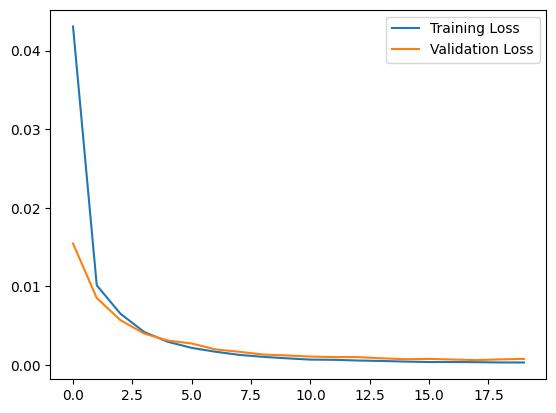

In [6]:
from itertools import product

hidden_layers = [64, 128]
learning_rates = [0.01, 0.001]

results = []

for hl, lr in product(hidden_layers, learning_rates):
    print(f"Testing model with {hl} hidden neurons and {lr} learning rate")

    model = build_model(hidden_neurons=hl, learning_rate=lr)
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
    loss, mae = model.evaluate(X_test, Y_test, verbose=0)
    results.append((hl, lr, loss, mae))

# Riporta i risultati migliori
for res in results:
    print(f"Hidden Neurons: {res[0]}, Learning Rate: {res[1]}, Loss: {res[2]}, MAE: {res[3]}")
# Ordina i risultati per loss
sorted_results = sorted(results, key=lambda x: x[2])  # Ordina per perdita
best_config = sorted_results[0]
print(f"Miglior configurazione trovata: Neuroni Nascosti={best_config[0]}, Learning Rate={best_config[1]}")
# Usa i parametri ottimali
optimal_hidden_neurons = best_config[0]
optimal_learning_rate = best_config[1]

# Costruisci e addestra il modello finale
model = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)


# Valuta il modello finale
loss, mae = model.evaluate(X_test, Y_test)
print(f"Perdita sul Test Set: {loss}, MAE sul Test Set: {mae}")

# Traccia l'andamento della perdita
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()




#Definizione dei jacobiani

In [9]:
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)  # Forward pass
    return tape.jacobian(y, x)

def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, 5))
    out = model(t)
    # Reshape to 1d vector
    out = tf.reshape(out, shape=(2,))
    return out

import numpy as np

def analytical_J_5R(theta, L=[0.1, 0.1, 0.1, 0.1, 0.1]):
    """
    Calcola la Jacobiana analitica per un robot 5R.
    """
    theta = np.cumsum(theta)  # Somma cumulativa degli angoli
    J = np.zeros((2, 5))

    # Calcolo delle derivate
    for i in range(5):
        J[0, i] = -sum(L[j] * np.sin(theta[j]) for j in range(i, 5))  # Derivata parziale di x
        J[1, i] = sum(L[j] * np.cos(theta[j]) for j in range(i, 5))   # Derivata parziale di y

    return J


In [10]:
# Esempio di confronto
theta_sample = X_test[0]  # Primo esempio di test
jacobian_learned = FK_Jacobian(model, tf.convert_to_tensor([theta_sample], dtype=tf.float32))
jacobian_analytical = analytical_J_5R(theta_sample)
import numpy as np

# Supponiamo che jacobian_learned e jacobian_analytical siano già calcolate
# Flatten delle matrici
jacobian_learned_flat = jacobian_learned.numpy().flatten()
jacobian_analytical_flat = jacobian_analytical.flatten()

# Calcolo del MSE
mse = np.mean((jacobian_learned_flat - jacobian_analytical_flat) ** 2)

# Output
print("Jacobiana appresa (flatten):\n", jacobian_learned_flat)
print()
print("Jacobiana analitica (flatten):\n", jacobian_analytical_flat)
print()
print(f"Mean Squared Error (MSE): {mse}")

print("Jacobiana appresa:\n", jacobian_learned.numpy())
print();
print("Jacobiana analitica:\n", jacobian_analytical)



Jacobiana appresa (flatten):
 [-0.06759153  0.10514703  0.07115312 -0.00839201  0.124034    0.36303318
  0.03838249  0.02635653  0.08462036 -0.13087468]

Jacobiana analitica (flatten):
 [-0.36694948 -0.31519321 -0.21527005 -0.16286561 -0.0658326  -0.1029756
 -0.18854013 -0.18462077 -0.09945167 -0.0752733 ]

Mean Squared Error (MSE): 0.07583942474973701
Jacobiana appresa:
 [[[-0.06759153  0.10514703  0.07115312 -0.00839201  0.124034  ]]

 [[ 0.36303318  0.03838249  0.02635653  0.08462036 -0.13087468]]]

Jacobiana analitica:
 [[-0.36694948 -0.31519321 -0.21527005 -0.16286561 -0.0658326 ]
 [-0.1029756  -0.18854013 -0.18462077 -0.09945167 -0.0752733 ]]
